## Import Modules and Libraries

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


## Import CiFAR Dataset
- It is a more advance dataset compared to MNIST
- It has 10 classes 
- The dimension of the images are 32x32x3 since it is a RGB image
- Shown below are the classses in the CiFAR dataset
- Like MNIST, CiFAR also has 50K training images and labels as well as 10K test images and labels

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Print training data dimensions

In [3]:
print(train_features.shape)

(50000, 32, 32, 3)


## Displaying a sample from each class of the dataset

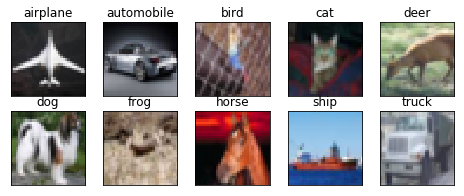

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for plotting accuracy and loss during model training

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Accuracy Calculation for a model

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Data Float Conversion , remapping pixel values between 0 & 1, and One-Hot encoding

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Model Architecture and Compiling Model
- This model is built using functional API and not Sequential model
- This model consists of various types of convolutions like Depthwise Separable convolution, Dilated convolution, Spatial Separable convolution, and grouped convolutions
- ### Separable Convolution:
  ![](SeparableConv.gif)
  - They are extensively used in Inception and Xception networks
  - Instead of using 3x3, we use 3x1 and then 1x3 over an image
  - This reduces the parameters by around 66%
  - The accuracy drop is around 0.2-0.8%
  
- ### Depthwise Convolution:
  ![](depthwise.gif)
  - We divide the depth i.e. the channels and convolve witht a kernel on each of the channel
  - Then we concaenatet the output and use 1x1 to get the output
  - Huge number of parameters are reduced using depthwise convolution
  
  
- ### Dilated Convolution
![](dilated.gif)
  - It is mostly used for segmentation network
  - It increases the receptive field of the network

- ### Grouped Convolutions:
  ![](grouped.png)
  - Different types of convolutions are used parallely to improve the detection result
  - It is useful to detect objects with different sizes in the network

In [9]:
input = Input(shape=(32, 32, 3,))

# Dropout rate
drop = 0.35

# Convolution Block
layer1 = Convolution2D(32, 3, 3, border_mode='same')(input)   
layer2 = Activation('relu')(layer1)
layer3 = BatchNormalization()(layer2)
layer4 = SeparableConv2D(64, 3, 3, border_mode='same')(layer3)                          # Separable Convolution                        
layer5 = Activation('relu')(layer4)
layer6 = BatchNormalization()(layer5)
layer7 = SeparableConv2D(128, 3, 3, border_mode='same', depth_multiplier = 1)(layer6)   # Depthwise Convolution
layer8 = Activation('relu')(layer7)
layer9 = BatchNormalization()(layer8)

layer10 = Dropout(drop)(layer9)

# Transition Block
layer11 = MaxPooling2D(pool_size=(2, 2))(layer10)                                       
layer12 = Convolution2D(64, 1, 1)(layer11)                                              
layer13 = Activation('relu')(layer12)
layer14 = BatchNormalization()(layer13)

# Convolution Block
layer15 = Convolution2D(64, 3, 3, border_mode='same')(layer14)                          # Normal 3x3
layer16 = Activation('relu')(layer15)
layer17 = BatchNormalization()(layer16)

layer18 = Convolution2D(64, 5, 5, border_mode='same')(layer14)                          # Normal 5x5
layer19 = BatchNormalization()(layer18)
layer20 = Activation('relu')(layer19)

layer21 = concatenate([layer17, layer20])                                               # Concatenation (Grouped Convolution)

layer22 = Dropout(drop)(layer21)

# Transition Block
layer23 = Convolution2D(64, 1, 1)(layer22)                                             
layer24 = Activation('relu')(layer23)
layer25 = BatchNormalization()(layer24)
layer26 = MaxPooling2D(pool_size=(2, 2))(layer25)                                      


# Convolution Block
layer27 = Convolution2D(64, 3, 3, border_mode='same')(layer26)                          # Normal 3x3                    
layer28 = Activation('relu')(layer27)
layer29 = BatchNormalization()(layer28)

layer30 = Convolution2D(64, 3, 3, border_mode='same', dilation_rate = 1)(layer26)       # Dilated convolution with rate=1
layer31 = Activation('relu')(layer30)
layer32 = BatchNormalization()(layer31)

layer33 = Convolution2D(64, 3, 3, border_mode='same', dilation_rate = 2)(layer26)       # Dilated convolution with rate=2
layer34 = Activation('relu')(layer33)
layer35 = BatchNormalization()(layer34)

layer36 = concatenate([layer29, layer32, layer35])                                      # Concatenated for grouped convolution

layer37 = Dropout(drop)(layer36)

# Transition Block
layer38 = Convolution2D(64, 1, 1)(layer37)                                             
layer39 = BatchNormalization()(layer38)
layer40 = Convolution2D(num_classes, 8, 8)(layer39)                                    

# Output Block
layer41 = Flatten()(layer40)                                                           
layer42 = Activation('softmax')(layer41)

model = Model(inputs=[input], outputs=[layer42])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), dilation_rate=2, padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `

## Model Summary

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 32, 32, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 32, 32)   128         activation_7[0][0]               
__________________________________________________________________________________________________
separable_

## Training and tracking progress

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 32s 83ms/step - loss: 1.5241 - acc: 0.4772 - val_loss: 1.9425 - val_acc: 0.4091
Epoch 2/50
390/390 [==============================] - 28s 73ms/step - loss: 1.0142 - acc: 0.6489 - val_loss: 1.4009 - val_acc: 0.5532
Epoch 3/50
390/390 [==============================] - 28s 72ms/step - loss: 0.8140 - acc: 0.7166 - val_loss: 1.1993 - val_acc: 0.6302
Epoch 4/50
390/390 [==============================] - 28s 72ms/step - loss: 0.7004 - acc: 0.7554 - val_loss: 1.2401 - val_acc: 0.6111
Epoch 5/50
390/390 [==============================] - 28s 72ms/step - loss: 0.6162 - acc: 0.7841 - val_loss: 1.0088 - val_acc: 0.6803
Epoch 6/50
390/390 [==============================] - 28s 72ms/step - loss: 0.5624 - acc: 0.8031 - val_loss: 1.0387 - val_acc: 0.6822
Epoch 7/50
390/390 [==============================] - 28s 72ms/step - loss: 0.5079 - acc: 0.8228 - val_loss: 0.9782 - val_acc: 0.7124
Epoch 8/50
390/390 [==============================] - 28s 72ms

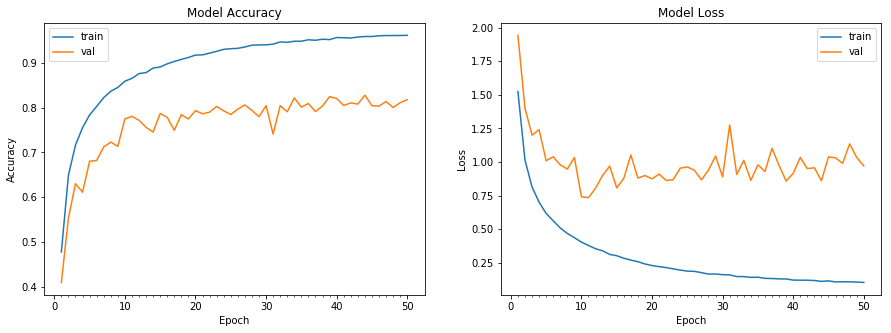

Accuracy on test data is: 81.82


In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))